In [3]:
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from analysis import *



c:\Users\santh\Desktop\Python Projects\Masters Thesis\Multi_particleTracking\Multi_particle_Auto-tracker\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\Users\santh\Desktop\Python Projects\Masters Thesis\Multi_particleTracking\Multi_particle_Auto-tracker\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


In [103]:
def loader():
    img_list = os.listdir("./Train_imgs")
    count = 1
    while count != len(img_list):
        img = plt.imread("./Train_imgs/"+img_list[count-1])
        count +=1
        yield img

In [104]:
gen = loader()
img_list =[]


In [157]:
a = gen.__next__()
plt.imshow(a)

StopIteration: 

In [155]:
img_list.append(a[10:30, 6:26])#

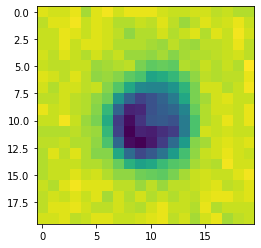

In [156]:
plt.imshow(img_list[14])

In [158]:
count = 0
for img in img_list:
    
    np.save(f"./train_images/{count}.npy", img)
    count+=1

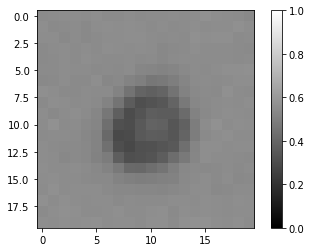

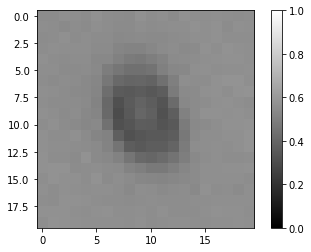

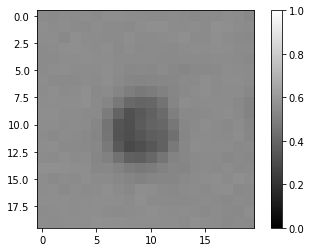

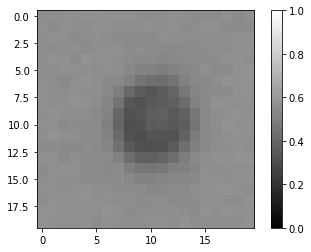

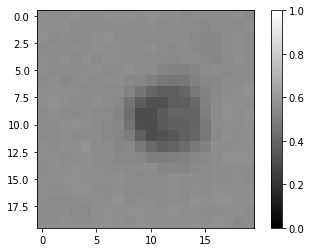

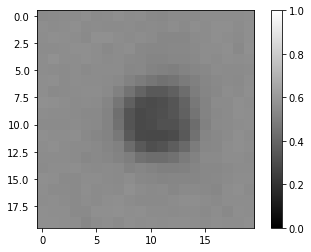

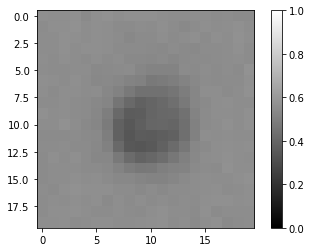

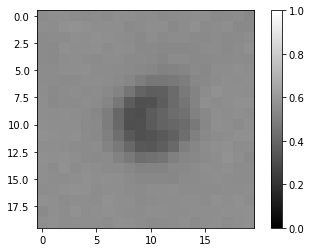

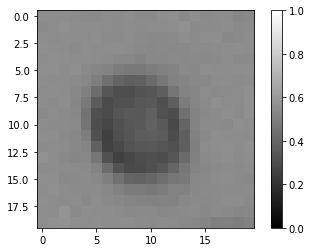

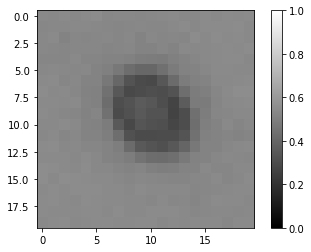

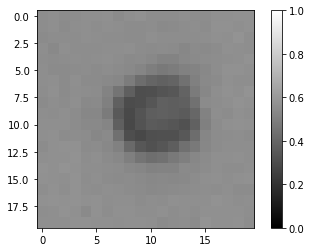

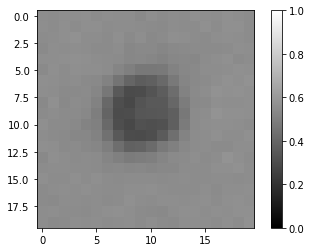

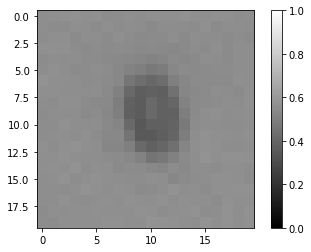

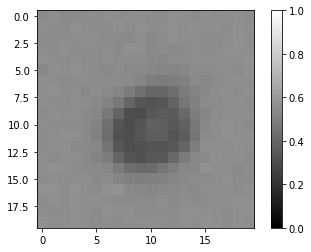

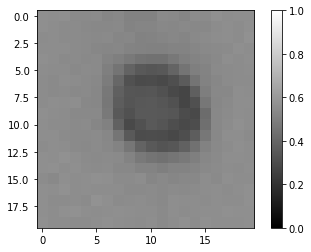

In [160]:
img_list = []
for fileName in os.listdir("./train_images") :
    im = np.load("./train_images/"+fileName)/255
    im = np.expand_dims(im, axis = 2)
    plt.imshow(im, cmap = "gray", vmin = 0, vmax =1)
    plt.colorbar()
    plt.show()
    img_list.append(im)
    

In [187]:
import random
training_set = dt.Value(lambda: random.choice(img_list)) \
     >> dt.Add(lambda: np.random.randn() * 0.05) #>> dt.Multiply(lambda: np.random.uniform(0.8, 1))

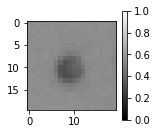

In [204]:
plt.figure(figsize=(2, 2))
plt.imshow(training_set.update().resolve(), cmap = "gray", vmin = 0, vmax = 1)
plt.colorbar()

In [205]:
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    num_outputs = 2,  
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201
)

In [ ]:
with generator:
    img = generator[0]

In [65]:
img, label = generator[7]


In [4]:
import tensorflow as tf
model = dt.models.LodeSTAR(input_shape=(None, None, 1), num_outputs=2)
model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

In [207]:
with generator:
    
    model.fit(generator, epochs=50, steps_per_epoch=100)

Generating 201 / 200 samples before starting training
Epoch 1/50
100/100 [==============================] - 12s 52ms/step - total_loss: 2.2007 - consistency_loss: 0.7242
Epoch 2/50
100/100 [==============================] - 5s 53ms/step - total_loss: 1.2402 - consistency_loss: 0.3474
Epoch 3/50
100/100 [==============================] - 5s 51ms/step - total_loss: 0.4863 - consistency_loss: 0.1269 1s - total_loss: 0.569 - ETA: 0s - total_loss: 0.5028 - consistency_lo
Epoch 4/50
100/100 [==============================] - 5s 51ms/step - total_loss: 0.1909 - consistency_loss: 0.0503
Epoch 5/50
100/100 [==============================] - 6s 64ms/step - total_loss: 0.1736 - consistency_loss: 0.0432 0s - total_loss: 0.1654 - co
Epoch 6/50
100/100 [==============================] - 6s 61ms/step - total_loss: 0.2535 - consistency_loss: 0.0485 3s - total_loss: 0.2959 -  - ETA: 1s - total_loss: 0.2311 - co - ETA: 0s - total_loss: 0.2571 - co
Epoch 7/50
100/100 [==============================] - 6s

In [208]:
model.save("./network_auto_tracker_copy2_4")

INFO:tensorflow:Assets written to: ./network_auto_tracker_copy2_4\assets


In [5]:
model.load_weights("./network_auto_tracker_copy2_4")

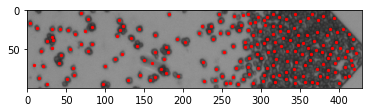

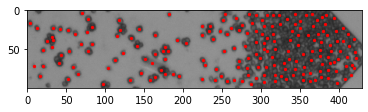

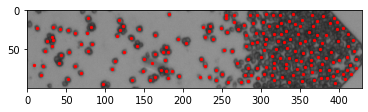

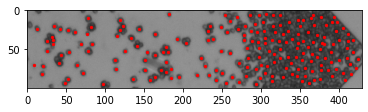

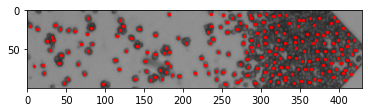

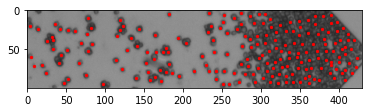

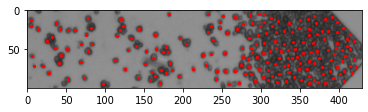

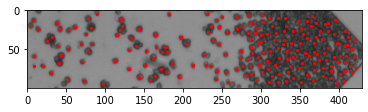

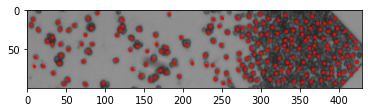

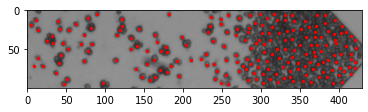

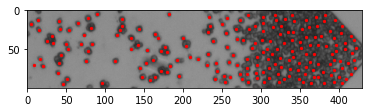

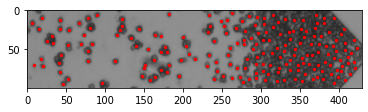

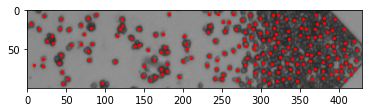

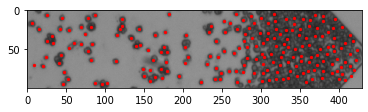

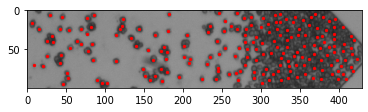

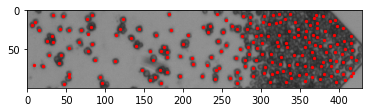

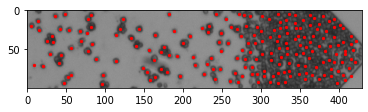

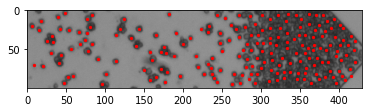

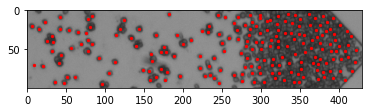

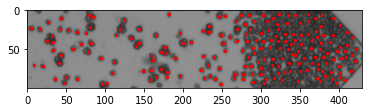

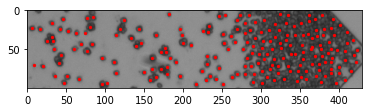

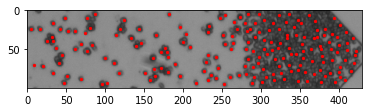

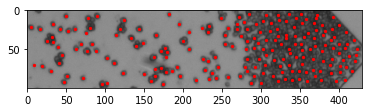

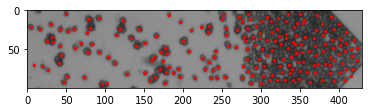

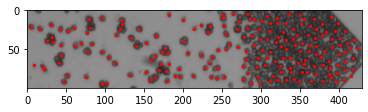

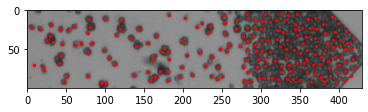

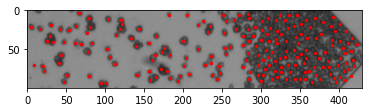

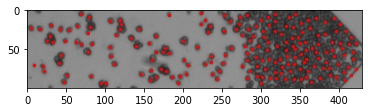

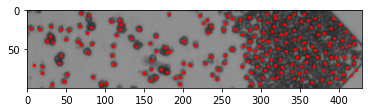

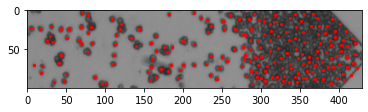

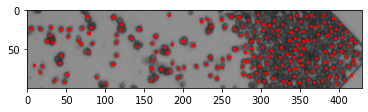

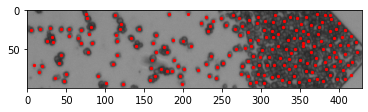

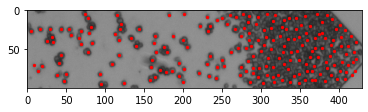

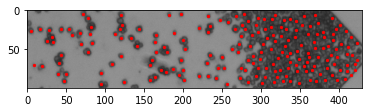

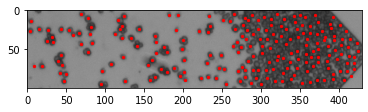

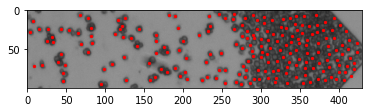

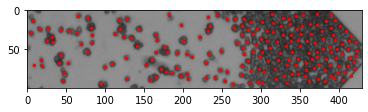

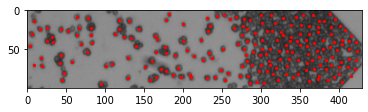

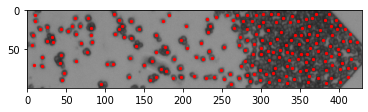

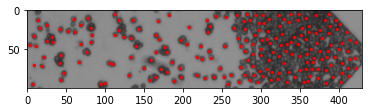

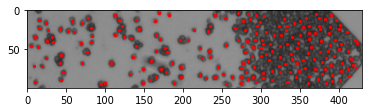

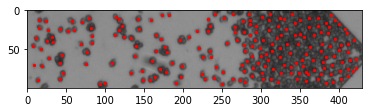

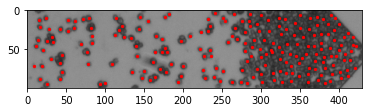

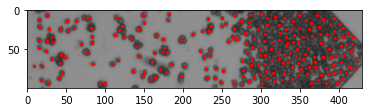

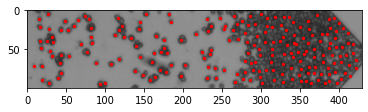

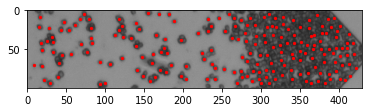

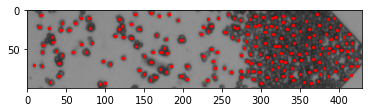

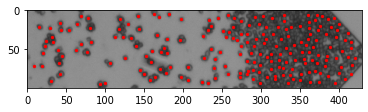

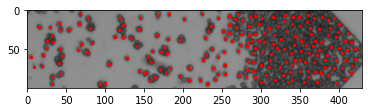

In [12]:
#May need to tune these to get optimal performance!
alpha = .7
cutoff = 0.8
test_img_dir = "./New sequence testing"
count = 0
for fileName in os.listdir(test_img_dir):
    if count >= 50:
        break
    count += 1
    img = np.array(Image.open(test_img_dir+"/"+fileName))/255
    img = img[:,100:530]
    img = np.expand_dims(img, axis = 2)
    detections = model.predict_and_detect(img[np.newaxis], alpha=alpha, beta=.3, cutoff=cutoff, mode="quantile")[0]#1-alpha

    #plt.figure(figsize=(15, 30))
    """plt.imshow(img, cmap = "gray", vmin = 0, vmax = 1)
    plt.show()"""
    plt.imshow(img, cmap = "gray", vmin = 0, vmax = 1)
    #plt.axis("off")
    plt.scatter(detections[:, 1], detections[:, 0],s = 5, color="r")
    
    plt.show()
    

In [211]:
import cv2
import os


images = [img for img in os.listdir(test_img_dir) if img.endswith(".jpg")]





for image in images:
    img = np.array(Image.open(os.path.join(test_img_dir, image)))/255
    img = img[:,100:530]
    img = np.expand_dims(img, axis = 2)
    detections = model.predict_and_detect(img[np.newaxis], alpha=alpha, beta=.3, cutoff=cutoff, mode="quantile")[0]
    #plt.figure(figsize=(50,10))
    plt.imshow(img, cmap = "gray", vmin = 0, vmax = 1)
    #plt.axis("off")
    plt.scatter(detections[:, 1], detections[:, 0], s = 2, color="r")
    #plt.show()
    plt.savefig("./Results/copy2_4/{}".format(image))
    plt.clf()
    


<Figure size 432x288 with 0 Axes>

## Video

In [32]:
video_name = 'video_centroids_copy2_2.avi'

frame = Image.open(os.path.join(test_img_dir, images[0]))
height, width = np.shape(np.array(frame))

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(np.array(Image.open(os.path.join("./Results/copy2_2", image))))

cv2.destroyAllWindows()
video.release()

## Creating dataframe for tracking

In [7]:
im = []
count = 0
no_of_frames = 20
for filename in os.listdir("C:/Users/santh/Desktop/Python Projects/Masters Thesis/Multi_particleTracking/Multi_particle_YOLO_simulation/New sequence testing 2"):
    if count >= no_of_frames:
        break
    count += 1
    img = np.array(Image.open('C:/Users/santh/Desktop/Python Projects/Masters Thesis/Multi_particleTracking/Multi_particle_YOLO_simulation/New sequence testing 2/'+filename))
    im.append(img)

In [10]:
data = []
for i in range(len(im)):
    for l in range(len(detections)):
        #radius = (abs(frames_particles_inGlobalCoord[i][l,1]-frames_particles_inGlobalCoord[i][l,0])/2.0)/ 3.0
        [centroid_x, centroid_y] = [detections[l, 1], detections[l, 0]]
        centroid_x /= np.max(detections)
        centroid_y /= np.max(detections)
        frame = i
        #intensity = im[i][int(centroid_x),int(centroid_y)] / 70.0
        set = 0
        label = 0
        solution = 0
        data.append([centroid_x, centroid_y, frame, set, label, solution])

In [11]:
# Create the pandas DataFrame
import pandas as pd
df = pd.DataFrame(data, columns = ['centroid_x', 'centroid_y', 'frame', 'set', 'label', 'solution'])
df

,centroid_x,centroid_y,frame,set,label,solution
0,0.161049,0.054775,0,0,0,0
1,0.397791,0.061058,0,0,0,0
2,0.431811,0.056163,0,0,0,0
3,0.532248,0.045908,0,0,0,0
4,0.642476,0.043812,0,0,0,0
...,...,...,...,...,...,...
4075,0.770200,0.970105,19,0,0,0
4076,0.793632,0.975207,19,0,0,0
4077,0.844947,0.976265,19,0,0,0
4078,0.883863,0.974728,19,0,0,0


In [ ]:
df.to_csv('./df_copy2_4.csv', index=False)